In [48]:
!git clone https://github.com/minakshimathpal/EVA-Computer-Vision-Using-Pytorch.git

Cloning into 'EVA-Computer-Vision-Using-Pytorch'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 87 (delta 17), reused 0 (delta 0), pack-reused 46
Unpacking objects: 100% (87/87), 1.20 MiB | 8.38 MiB/s, done.


In [43]:
# !rm -rf /content/EVA-Computer-Vision-Using-Pytorch

In [1]:
%cd /content/EVA-Computer-Vision-Using-Pytorch     
!pwd

/content/EVA-Computer-Vision-Using-Pytorch
/content/EVA-Computer-Vision-Using-Pytorch


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision import datasets,transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from session_5.model import Net
import matplotlib.pyplot as plt
import seaborn as sns
seed=42

## Lets Download the Data  with some transforms discussed above. We will use this data for training
The PyTorch torchvision library provides us with an MNIST dataset, which downloads the data and provides it in a readily-usable format. Let's use the dataset MNIST function to pull the dataset to our local machine, and then wrap it around a DataLoader. We will use torchvision transformations to convert the data into PyTorch tensors and do data normalization. The following code takes care of downloading, wrapping around the DataLoader and normalizing the data:

**Steps**
1. Initialize transformation
2. Load the data from torchvision dataset
3. Create a dataloader using the data from above step

In [3]:
train_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                    #  transforms.RandomVerticalFlip(p=0.5),
                                    #  transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomRotation(degrees=(-7.0, 7.0),fill=(1,))          
                                     
                                     ])

test_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,)),                                     
                                     ])          

In [4]:
# get train_set
train_set= datasets.MNIST(root="./data",train=True,download=True,transform=train_transforms)
test_set= datasets.MNIST(root="./data",train=False,download=True,transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# CUDA?
is_cuda= torch.cuda.is_available()
print("CUDA Available?",is_cuda)

 #for Reproduciability
torch.manual_seed(seed)


if is_cuda:
  torch.cuda.manual_seed(seed)

device= torch.device("cuda" if is_cuda else "cpu" )  

# Data Loader Arguments - something you will fetch these from Command Prompt 
dataloader_args=dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if is_cuda else dict(shuffle=True,batch_size=64)

# train loader 
train_loader=torch.utils.data.DataLoader(train_set,**dataloader_args)
test_loader= torch.utils.data.DataLoader(test_set,**dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# training block
from tqdm import tqdm

def train(data_loader,model,optimizer,L1_regularization="false"):
    model.train() # set the mode(train/test)
    progress_bar= tqdm(data_loader)
    running_loss=0.0
    running_correct= 0

    # iterate over data- Access batch_id and images and labels
    for batch_idx,(images,target) in enumerate(progress_bar):
      # get samples
      images,target= images.to(device),target.to(device)      
      
      # compute prediction error
      y_pred= model(images)
      loss= F.nll_loss(y_pred,target)

      # Compute L1 loss component
      if L1_regularization.lower() == "true":
        l2_lambda = 0.0001
        l1_parameters = []
        for parameter in model.parameters():
            l1_parameters.append(parameter.view(-1))
        l1 = l2_lambda * model.compute_l1_loss(torch.cat(l1_parameters))            
        # Add L1 loss component
        loss += l1      
      running_loss+=loss.item() # accumulating loss across every batch
      preds= y_pred.argmax(dim=1,keepdims=True) # get the index of the max log-probability
      running_correct+=preds.eq(target.view_as(preds)).cpu().sum().item()

      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
      # Backpropogation  
      optimizer.zero_grad()          
      loss.backward()
      optimizer.step()     

    # calculate Loss and accuracy accross every epoch
    loss= running_loss/len(data_loader.dataset)
    accuracy=100*(running_correct/len(data_loader.dataset))  

    print(f'LR={optimizer.param_groups[0]["lr"]} Training Loss {loss} Training Accuracy {accuracy:.2f}')    
    return loss, accuracy

def test(data_loader,model,optimizer):
  model.eval()
  progress_bar= tqdm(data_loader)
  running_loss=0.0
  running_correct= 0

  with torch.no_grad():
    for batch_idx,(images,target) in enumerate(progress_bar):
      # get samples
      images,target= images.to(device),target.to(device)

      # prediction
      y_preds= model(images)
      loss=F.nll_loss(y_preds,target)
      running_loss+=loss.item()
      preds= y_preds.argmax(dim=1,keepdims=True) # get the index of the max log-probability
      running_correct+=preds.eq(target.view_as(preds)).cpu().sum().item()

    loss= running_loss/len(data_loader.dataset)
    accuracy=100*(running_correct/len(data_loader.dataset)) 
    print(f"Validation Loss {loss} Validation Accuracy {accuracy:.2f}")
    return loss,accuracy

def instantiateModel(norm_type,n_groups,dropout_value):
  print("+++++++++++++++++++",f"Using {norm_type}","++++++++++++++++")
  model=Net(norm_type=norm_type,n_groups=n_groups,dropout_value=dropout_value).to(device)
  optimizer=optim.Adam(model.parameters(),lr=2.15E-02)
  return model, optimizer     


In [9]:
Epochs= int(input("Enter the number of epochs"))
norm_type= input("Enter the type of normalization")
dropout_value=float(input("Eneter the dropout_value"))
n_groups= int(input("Enter the number of groups(Pass n_groups as 1 if using Layer Norm and 0 if using Batch norm"))
l1_regularization=input("Do you wish to use L1 regularization True/False").lower()


Enter the number of epochs20
Enter the type of normalizationLN
Eneter the dropout_value0.05
Enter the number of groups(Pass n_groups as 1 if using Layer Norm and 0 if using Batch norm1
Do you wish to use L1 regularization True/Falsetrue


In [35]:

def plot_missclassification(model,test_loader):
  model.eval()
  misclassified_images = []    
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, pred = torch.max(output, 1)
          for i in range(len(pred)):
              if pred[i] != target[i]:
                  
                  misclassified_images.append({'image': data[i], 'predicted_class': pred[i], 'correct_class': target[i]})

 # Plot the misclassified images
  fig = plt.figure(figsize=(15, 5))
  for i in range(10):
      sub = fig.add_subplot(2, 5, i+1)
      misclassified_image = misclassified_images[i]
      plt.imshow(misclassified_image['image'].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
      sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
  plt.tight_layout()
  plt.show()

In [11]:
# if __name__=="__main__":
model,optimizer= instantiateModel(norm_type,n_groups,dropout_value)  
summary(model,input_size=(1,28,28)) 
scheduler= ReduceLROnPlateau(optimizer,threshold=0.0001,patience=1,factor=.215,mode='max')
  
 
losses, accuracy={},{}
losses["train"]=[]
losses["val"]=[]
accuracy["train"]=[]
accuracy["val"]=[]
for epoch in range(Epochs):
  print(f"EPOCH {epoch}")
  train_epoch_loss,train_epoch_accuracy = train(train_loader,model,optimizer,L1_regularization)
  val_epoch_loss,val_epoch_accuracy = test(test_loader,model,optimizer)

  scheduler.step(val_epoch_accuracy)
  losses["train"].append(train_epoch_loss)
  accuracy["train"].append(train_epoch_accuracy)

  losses["val"].append(val_epoch_loss)
  accuracy["val"].append(val_epoch_accuracy)
print(len(losses["train"]))


+++++++++++++++++++ Using LN ++++++++++++++++
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
        GroupNorm-13           [-1, 20, 10, 10]          

100%|██████████| 469/469 [00:30<00:00, 15.13it/s]


LR=0.0215 Training Loss 0.0047418147469560305 Training Accuracy 83.95


100%|██████████| 79/79 [00:02<00:00, 35.10it/s]


Validation Loss 0.0009741483449935913 Validation Accuracy 96.19
EPOCH 1


100%|██████████| 469/469 [00:31<00:00, 14.84it/s]


LR=0.0215 Training Loss 0.0019783499588569005 Training Accuracy 96.42


100%|██████████| 79/79 [00:02<00:00, 35.94it/s]


Validation Loss 0.0007121714979410171 Validation Accuracy 97.38
EPOCH 2


100%|██████████| 469/469 [00:31<00:00, 14.89it/s]


LR=0.0215 Training Loss 0.0018537023874620597 Training Accuracy 96.95


100%|██████████| 79/79 [00:02<00:00, 35.90it/s]


Validation Loss 0.0004828257596120238 Validation Accuracy 98.03
EPOCH 3


100%|██████████| 469/469 [00:33<00:00, 13.97it/s]


LR=0.0215 Training Loss 0.0017328449728588264 Training Accuracy 97.34


100%|██████████| 79/79 [00:02<00:00, 36.30it/s]


Validation Loss 0.000335379491513595 Validation Accuracy 98.65
EPOCH 4


100%|██████████| 469/469 [00:31<00:00, 14.68it/s]


LR=0.0215 Training Loss 0.0017190720749398073 Training Accuracy 97.31


100%|██████████| 79/79 [00:02<00:00, 35.51it/s]


Validation Loss 0.0004122324242256582 Validation Accuracy 98.27
EPOCH 5


100%|██████████| 469/469 [00:32<00:00, 14.29it/s]


LR=0.0215 Training Loss 0.0016925129599869252 Training Accuracy 97.36


100%|██████████| 79/79 [00:02<00:00, 35.03it/s]


Validation Loss 0.0003420062010642141 Validation Accuracy 98.64
EPOCH 6


100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


LR=0.0046225 Training Loss 0.0013274515704562266 Training Accuracy 98.41


100%|██████████| 79/79 [00:02<00:00, 35.91it/s]


Validation Loss 0.00022904610440600663 Validation Accuracy 99.08
EPOCH 7


100%|██████████| 469/469 [00:31<00:00, 14.96it/s]


LR=0.0046225 Training Loss 0.0012236672396461169 Training Accuracy 98.46


100%|██████████| 79/79 [00:02<00:00, 35.25it/s]


Validation Loss 0.00026943830237723885 Validation Accuracy 98.92
EPOCH 8


100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


LR=0.0046225 Training Loss 0.001173650160804391 Training Accuracy 98.45


100%|██████████| 79/79 [00:02<00:00, 35.82it/s]


Validation Loss 0.00024891354070277885 Validation Accuracy 99.03
EPOCH 9


100%|██████████| 469/469 [00:31<00:00, 14.95it/s]


LR=0.0009938375 Training Loss 0.0010659741452584664 Training Accuracy 98.75


100%|██████████| 79/79 [00:02<00:00, 35.04it/s]


Validation Loss 0.00019514542691613314 Validation Accuracy 99.23
EPOCH 10


100%|██████████| 469/469 [00:31<00:00, 14.92it/s]


LR=0.0009938375 Training Loss 0.0010243049057821433 Training Accuracy 98.77


100%|██████████| 79/79 [00:02<00:00, 35.21it/s]


Validation Loss 0.0002125149059924297 Validation Accuracy 99.24
EPOCH 11


100%|██████████| 469/469 [00:31<00:00, 14.92it/s]


LR=0.0009938375 Training Loss 0.0010039518954853216 Training Accuracy 98.82


100%|██████████| 79/79 [00:02<00:00, 35.96it/s]


Validation Loss 0.00019665437805233522 Validation Accuracy 99.21
EPOCH 12


100%|██████████| 469/469 [00:31<00:00, 14.82it/s]


LR=0.0009938375 Training Loss 0.000988619918252031 Training Accuracy 98.87


100%|██████████| 79/79 [00:02<00:00, 35.76it/s]


Validation Loss 0.0001963266395032406 Validation Accuracy 99.27
EPOCH 13


100%|██████████| 469/469 [00:31<00:00, 14.67it/s]


LR=0.0009938375 Training Loss 0.0009707247448464234 Training Accuracy 98.79


100%|██████████| 79/79 [00:02<00:00, 27.80it/s]


Validation Loss 0.00018217871839297005 Validation Accuracy 99.27
EPOCH 14


100%|██████████| 469/469 [00:33<00:00, 13.99it/s]


LR=0.0009938375 Training Loss 0.0009546097278594971 Training Accuracy 98.81


100%|██████████| 79/79 [00:02<00:00, 33.87it/s]


Validation Loss 0.0001919085774861742 Validation Accuracy 99.31
EPOCH 15


100%|██████████| 469/469 [00:35<00:00, 13.34it/s]


LR=0.0009938375 Training Loss 0.0009496980688224236 Training Accuracy 98.80


100%|██████████| 79/79 [00:02<00:00, 33.87it/s]


Validation Loss 0.0002097257920075208 Validation Accuracy 99.20
EPOCH 16


100%|██████████| 469/469 [00:33<00:00, 14.17it/s]


LR=0.0009938375 Training Loss 0.0009397700015455484 Training Accuracy 98.86


100%|██████████| 79/79 [00:02<00:00, 33.42it/s]


Validation Loss 0.00019718740825192072 Validation Accuracy 99.18
EPOCH 17


100%|██████████| 469/469 [00:38<00:00, 12.28it/s]


LR=0.0002136750625 Training Loss 0.0009079877247412999 Training Accuracy 98.86


100%|██████████| 79/79 [00:02<00:00, 33.92it/s]


Validation Loss 0.00018582386957714334 Validation Accuracy 99.28
EPOCH 18


100%|██████████| 469/469 [00:32<00:00, 14.30it/s]


LR=0.0002136750625 Training Loss 0.0008946773134171962 Training Accuracy 98.91


100%|██████████| 79/79 [00:02<00:00, 35.16it/s]


Validation Loss 0.0001846825156826526 Validation Accuracy 99.32
EPOCH 19


100%|██████████| 469/469 [00:33<00:00, 13.93it/s]


LR=0.0002136750625 Training Loss 0.0008987734328955412 Training Accuracy 98.87


100%|██████████| 79/79 [00:02<00:00, 31.71it/s]

Validation Loss 0.0001811277953442186 Validation Accuracy 99.33
20


NameError: ignored

### Batch Borm with L1


In [14]:
model=Net(norm_type="BN",n_groups=n_groups,dropout_value=dropout_value).to(device)
optimizer=optim.Adam(model.parameters(),lr=2.15E-02)
scheduler= ReduceLROnPlateau(optimizer,threshold=0.0001,patience=1,factor=.215,mode='max')
  
losses["train_BN"]=[]
losses["val_BN"]=[]
accuracy["train_BN"]=[]
accuracy["val_BN"]=[]

for epoch in range(Epochs):
  print(f"EPOCH {epoch}")
  train_epoch_loss,train_epoch_accuracy = train(train_loader,model,optimizer,L1_regularization="true")
  val_epoch_loss,val_epoch_accuracy = test(test_loader,model,optimizer)

  scheduler.step(val_epoch_accuracy)
  losses["train_BN"].append(train_epoch_loss)
  accuracy["train_BN"].append(train_epoch_accuracy)

  losses["val_BN"].append(val_epoch_loss)
  accuracy["val_BN"].append(val_epoch_accuracy)


EPOCH 0


100%|██████████| 469/469 [00:32<00:00, 14.54it/s]


LR=0.0215 Training Loss 0.0030225444587568444 Training Accuracy 92.77


100%|██████████| 79/79 [00:02<00:00, 35.40it/s]


Validation Loss 0.000499383105058223 Validation Accuracy 98.06
EPOCH 1


100%|██████████| 469/469 [00:30<00:00, 15.20it/s]


LR=0.0215 Training Loss 0.0018854744295279185 Training Accuracy 97.06


100%|██████████| 79/79 [00:02<00:00, 35.60it/s]


Validation Loss 0.0005104465499520302 Validation Accuracy 97.90
EPOCH 2


100%|██████████| 469/469 [00:31<00:00, 14.95it/s]


LR=0.0215 Training Loss 0.0017979539960622788 Training Accuracy 97.33


100%|██████████| 79/79 [00:02<00:00, 36.42it/s]


Validation Loss 0.0003871751842321828 Validation Accuracy 98.37
EPOCH 3


100%|██████████| 469/469 [00:34<00:00, 13.73it/s]


LR=0.0215 Training Loss 0.0017568933558960757 Training Accuracy 97.49


100%|██████████| 79/79 [00:02<00:00, 33.07it/s]


Validation Loss 0.0005644710058346391 Validation Accuracy 97.95
EPOCH 4


100%|██████████| 469/469 [00:31<00:00, 15.13it/s]


LR=0.0215 Training Loss 0.0017283893222610155 Training Accuracy 97.41


100%|██████████| 79/79 [00:02<00:00, 36.50it/s]


Validation Loss 0.0005230036076158285 Validation Accuracy 97.91
EPOCH 5


100%|██████████| 469/469 [00:31<00:00, 14.70it/s]


LR=0.0046225 Training Loss 0.0013323774135361114 Training Accuracy 98.58


100%|██████████| 79/79 [00:02<00:00, 34.54it/s]


Validation Loss 0.000207132406742312 Validation Accuracy 99.32
EPOCH 6


100%|██████████| 469/469 [00:31<00:00, 15.09it/s]


LR=0.0046225 Training Loss 0.0011857712980359793 Training Accuracy 98.58


100%|██████████| 79/79 [00:02<00:00, 35.44it/s]


Validation Loss 0.00022556442166678608 Validation Accuracy 99.10
EPOCH 7


100%|██████████| 469/469 [00:31<00:00, 15.13it/s]


LR=0.0046225 Training Loss 0.0011533239795515934 Training Accuracy 98.47


100%|██████████| 79/79 [00:02<00:00, 35.53it/s]


Validation Loss 0.0002072134257759899 Validation Accuracy 99.17
EPOCH 8


100%|██████████| 469/469 [00:30<00:00, 15.25it/s]


LR=0.0009938375 Training Loss 0.0010272338094810644 Training Accuracy 98.80


100%|██████████| 79/79 [00:02<00:00, 26.98it/s]


Validation Loss 0.0001720111061935313 Validation Accuracy 99.35
EPOCH 9


100%|██████████| 469/469 [00:37<00:00, 12.45it/s]


LR=0.0009938375 Training Loss 0.0009612394360204538 Training Accuracy 98.89


100%|██████████| 79/79 [00:02<00:00, 36.50it/s]


Validation Loss 0.00018152178274467588 Validation Accuracy 99.40
EPOCH 10


100%|██████████| 469/469 [00:32<00:00, 14.65it/s]


LR=0.0009938375 Training Loss 0.0009310660738497973 Training Accuracy 98.91


100%|██████████| 79/79 [00:02<00:00, 36.40it/s]


Validation Loss 0.00015344750229269265 Validation Accuracy 99.40
EPOCH 11


100%|██████████| 469/469 [00:35<00:00, 13.14it/s]


LR=0.0009938375 Training Loss 0.0009187717055281003 Training Accuracy 98.88


100%|██████████| 79/79 [00:02<00:00, 34.47it/s]


Validation Loss 0.000163741166156251 Validation Accuracy 99.32
EPOCH 12


100%|██████████| 469/469 [00:33<00:00, 14.02it/s]


LR=0.0002136750625 Training Loss 0.000879122661302487 Training Accuracy 98.98


100%|██████████| 79/79 [00:02<00:00, 27.75it/s]


Validation Loss 0.00015691033615730703 Validation Accuracy 99.39
EPOCH 13


100%|██████████| 469/469 [00:35<00:00, 13.13it/s]


LR=0.0002136750625 Training Loss 0.0008751785000165304 Training Accuracy 98.97


100%|██████████| 79/79 [00:02<00:00, 36.39it/s]


Validation Loss 0.00015268812021822668 Validation Accuracy 99.40
EPOCH 14


100%|██████████| 469/469 [00:31<00:00, 15.01it/s]


LR=4.59401384375e-05 Training Loss 0.0008580286247034868 Training Accuracy 99.03


100%|██████████| 79/79 [00:02<00:00, 35.65it/s]


Validation Loss 0.00015196751483017578 Validation Accuracy 99.39
EPOCH 15


100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


LR=4.59401384375e-05 Training Loss 0.000853456092129151 Training Accuracy 99.02


100%|██████████| 79/79 [00:02<00:00, 36.57it/s]


Validation Loss 0.00014953286342788487 Validation Accuracy 99.44
EPOCH 16


100%|██████████| 469/469 [00:31<00:00, 14.96it/s]


LR=4.59401384375e-05 Training Loss 0.0008642735136051973 Training Accuracy 99.00


100%|██████████| 79/79 [00:02<00:00, 36.39it/s]


Validation Loss 0.00015244356294861062 Validation Accuracy 99.43
EPOCH 17


100%|██████████| 469/469 [00:30<00:00, 15.22it/s]


LR=4.59401384375e-05 Training Loss 0.0008510884965459506 Training Accuracy 99.00


100%|██████████| 79/79 [00:02<00:00, 35.75it/s]


Validation Loss 0.0001512356463528704 Validation Accuracy 99.45
EPOCH 18


100%|██████████| 469/469 [00:30<00:00, 15.25it/s]


LR=4.59401384375e-05 Training Loss 0.0008480824204782645 Training Accuracy 99.05


100%|██████████| 79/79 [00:02<00:00, 36.43it/s]


Validation Loss 0.00014638590515241959 Validation Accuracy 99.43
EPOCH 19


100%|██████████| 469/469 [00:31<00:00, 14.70it/s]


LR=4.59401384375e-05 Training Loss 0.0008520517277220885 Training Accuracy 99.00


100%|██████████| 79/79 [00:02<00:00, 34.93it/s]

Validation Loss 0.0001501893810578622 Validation Accuracy 99.39


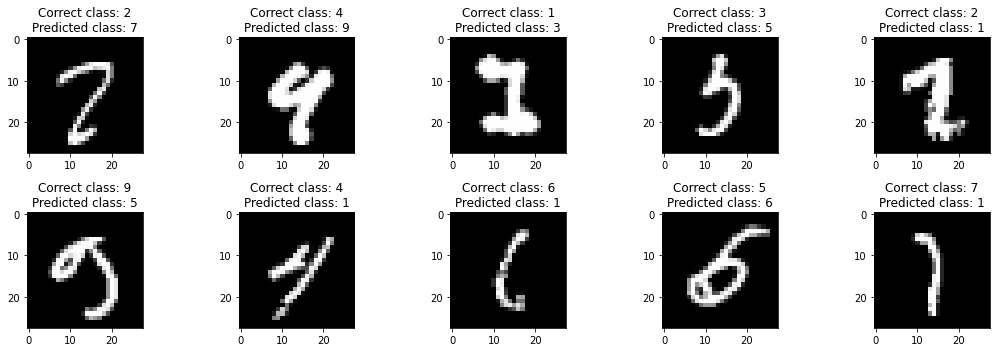

In [37]:
plot_missclassification(model, test_loader)

In [24]:
incorrect_examples[0].shape

(2, 28, 28)

TypeError: ignored

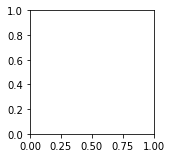

In [21]:
# Plot the misclassified images
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i+1)
    plt.imshow(incorrect_examples[i].squeeze(), cmap='gray', interpolation='none')
    sub.set_title("Correct class: {}\nPredicted class: {}".format(Actual_labels[i], incorrect_pred[i]))
plt.tight_layout()
plt.show()
     

In [ ]:
model=Net(norm_type="GN",n_groups=n_groups,dropout_value=dropout_value).to(device)
summary(model,input_size=(1,28,28)) 
optimizer=optim.Adam(model.parameters(),lr=2.15E-02)
scheduler= ReduceLROnPlateau(optimizer,threshold=0.0001,patience=1,factor=.215,mode='max')
  
losses["train_GN"]=[]
losses["val_GN"]=[]
accuracy["train_GN"]=[]
accuracy["val_GN"]=[]

for epoch in range(Epochs):
  print(f"EPOCH {epoch}")
  train_epoch_loss,train_epoch_accuracy = train(train_loader,model,optimizer,L1_regularization="true")
  val_epoch_loss,val_epoch_accuracy = test(test_loader,model,optimizer)

  scheduler.step(val_epoch_accuracy)
  losses["train_BN"].append(train_epoch_loss)
  accuracy["train_BN"].append(train_epoch_accuracy)

  losses["val_BN"].append(val_epoch_loss)
  accuracy["val_BN"].append(val_epoch_accuracy)
